## Makemore MLP

In [1]:
import torch

In [2]:
import torch.nn.functional as F

In [74]:
from matplotlib import pyplot as plt

### Build vocabulary

In [3]:
words = open('names.txt','r').read().splitlines()

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### Build dataset

In [5]:
block_size = 3
X, Y = [], []
for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)
        

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [7]:
C = torch.randn([27,2])
C[3]

tensor([ 1.2449, -0.3995])

In [8]:
F.one_hot(torch.tensor(3), num_classes=27).float() @ C

tensor([ 1.2449, -0.3995])

In [9]:
# 31th example 3rd character is an "a" = tensor(1)
X[31][2]

tensor(1)

In [10]:
emb = C[X]
# shape is [32,3,2] 32 training examples, of 3 (block size), 2 dimensions (embedding dimesion)
emb.shape

torch.Size([32, 3, 2])

In [11]:
emb[:,0,:].shape

torch.Size([32, 2])

### Weights and biases
We need to flatten one dimension to perform the multiplication. The input layer receives a vector of 3 by 2 (block size and embedding size) 

In [12]:
torch.cat(torch.unbind(emb,1),1).shape
# concatenation is ineffiecient and creates all kinds of memory

torch.Size([32, 6])

In [13]:
emb.view(32,6)

tensor([[-0.4918, -0.5377, -0.4918, -0.5377, -0.4918, -0.5377],
        [-0.4918, -0.5377, -0.4918, -0.5377, -0.5764, -0.1198],
        [-0.4918, -0.5377, -0.5764, -0.1198, -1.4281,  0.3479],
        [-0.5764, -0.1198, -1.4281,  0.3479, -1.4281,  0.3479],
        [-1.4281,  0.3479, -1.4281,  0.3479,  0.0317,  0.9032],
        [-0.4918, -0.5377, -0.4918, -0.5377, -0.4918, -0.5377],
        [-0.4918, -0.5377, -0.4918, -0.5377,  1.2473, -0.7499],
        [-0.4918, -0.5377,  1.2473, -0.7499,  0.5369,  0.6574],
        [ 1.2473, -0.7499,  0.5369,  0.6574,  0.0698, -0.4031],
        [ 0.5369,  0.6574,  0.0698, -0.4031,  0.6664, -0.5742],
        [ 0.0698, -0.4031,  0.6664, -0.5742,  0.0698, -0.4031],
        [ 0.6664, -0.5742,  0.0698, -0.4031,  0.0317,  0.9032],
        [-0.4918, -0.5377, -0.4918, -0.5377, -0.4918, -0.5377],
        [-0.4918, -0.5377, -0.4918, -0.5377,  0.0317,  0.9032],
        [-0.4918, -0.5377,  0.0317,  0.9032,  0.6664, -0.5742],
        [ 0.0317,  0.9032,  0.6664, -0.5

In [14]:
# input size and neurons

W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [15]:
h = emb.view(emb.shape[0], 6) @ W1 + b1
# or emb.view(-1, 6) with "-1" pytorch will infer what the other dimension should be to sum up to the correct one

In [16]:
# two broadcastable shapes:
(emb.view(emb.shape[0], 6) @ W1).shape, b1.shape

(torch.Size([32, 100]), torch.Size([100]))

In [17]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)

In [30]:
h.shape

torch.Size([32, 100])

In [19]:
# 27 characters are output
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [20]:
logits = h @ W2 + b2

In [36]:
logits.shape

torch.Size([32, 27])

In [21]:
logits.shape

torch.Size([32, 27])

In [37]:
counts = logits.exp()

In [40]:
counts.max()

tensor(1.5194e+12)

In [41]:
# counts are normalized so they sum to 1
prob = counts / counts.sum(1, keepdims = True)

In [42]:
prob[0].sum()

tensor(1.)

In [43]:
# actual probabilities for the correct output character (for now without training)
# torch.arange(32), Y this means "example i, character Y (the correct character)"
prob[torch.arange(32), Y]

tensor([4.4849e-05, 1.8640e-07, 3.1148e-06, 9.6532e-11, 1.3769e-05, 8.3945e-09,
        7.1073e-06, 5.9277e-06, 9.8619e-08, 1.9752e-06, 3.9194e-03, 7.9779e-06,
        1.8959e-06, 1.2318e-08, 5.9122e-02, 1.0168e-06, 5.7975e-07, 4.3573e-12,
        8.0100e-04, 2.6147e-08, 1.6556e-15, 2.4621e-13, 1.4649e-09, 3.2818e-04,
        6.6900e-07, 4.9880e-11, 9.8043e-10, 1.5874e-07, 5.1764e-08, 4.9212e-07,
        1.8086e-08, 4.8019e-09])

In [44]:
prob.shape

torch.Size([32, 27])

In [45]:
torch.arange(32), Y

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
          1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

In [46]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator = g)
W1 = torch.randn((6,100), generator = g)
b1 = torch.randn(100, generator = g)
W2 = torch.randn((100,27), generator = g)
b2 = torch.randn(27, generator = g)

In [47]:
parameters = [C, W1, b1, W2, b2]

In [48]:
num_params = sum(p.nelement() for p in parameters)
num_params

3481

In [49]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.7697)

In [50]:
# the previous cell is the same as cross_entropy
F.cross_entropy(logits, Y)

tensor(17.7697)

**cross entropy** measures the difference between two probability distributions. is used in classification problems. If $P$ is our target distribution (in this case $Y$) and $Q$ is an approximation of $Q$ (in this case $logits$), the **cross entropy** is computed as follows:
$$H(P,Q) = - \sum_{x \in X} P(x) \cdot \log{Q(x)}$$

In [51]:
for p in parameters:
    p.requires_grad = True

## Training Loop
#### Overfitting one batch of 32 examples

In [54]:
for _ in range(1000):
    # forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())

0.25285276770591736


#### Training on the full data set
Random selected minibatches are used to train the model. For each mini batch a gradient is computed and an optimization of the parameters is performed.

In [131]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator = g)
W1 = torch.randn((6,100), generator = g)
b1 = torch.randn(100, generator = g)
W2 = torch.randn((100,27), generator = g)
b2 = torch.randn(27, generator = g)

In [132]:
parameters = [C, W1, b1, W2, b2]

In [133]:
for p in parameters:
    p.requires_grad = True

In [134]:
iterations = 1000

In [136]:
loss_track = []
lr_track = []
for i in range(iterations):
    # getting random mini batches
    # 32 indices are randomly generated
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)

    # track
    loss_track.append(loss.item())
    lr_track.append(lre[i])
    # backward pass
    for p in parameters:
        p.grad = None

    # when .backward() is kicked off, the autograd function executes backprop differentiating the computational graph from p.
    loss.backward()
    
    # update
    for p in parameters:
        p.data += -lrs[i]*p.grad

#### Finding a good learning rate 
The idea is iterating into an exponential increasing list of learning rates and find which ones make the loss more stable

In [135]:
lre = torch.linspace(-3, 0, iterations)
lrs = 10**lre

In [87]:
loss_track

[6.503838539123535,
 4.964483261108398,
 6.206967830657959,
 5.436611652374268,
 4.725887775421143,
 5.5195631980896,
 5.554574012756348,
 5.680169582366943,
 5.765488147735596,
 4.831064224243164,
 4.659779071807861,
 5.629796504974365,
 5.905553340911865,
 5.640501499176025,
 5.351497650146484,
 4.634459495544434,
 4.279050350189209,
 5.392859935760498,
 5.101237773895264,
 5.3582353591918945,
 4.626509666442871,
 5.122476100921631,
 4.894629001617432,
 4.659432411193848,
 4.572819709777832,
 4.863282680511475,
 5.063176155090332,
 5.054225921630859,
 4.430258274078369,
 4.260829925537109,
 5.007784366607666,
 4.622195720672607,
 5.229585647583008,
 4.156047344207764,
 4.614228248596191,
 4.64133882522583,
 4.067047595977783,
 4.505004405975342,
 4.804667949676514,
 3.838247776031494,
 4.708486080169678,
 4.491815090179443,
 4.319787979125977,
 4.832242965698242,
 4.793335914611816,
 4.113579273223877,
 3.7352662086486816,
 4.056610584259033,
 3.861778736114502,
 3.380192279815674,
 

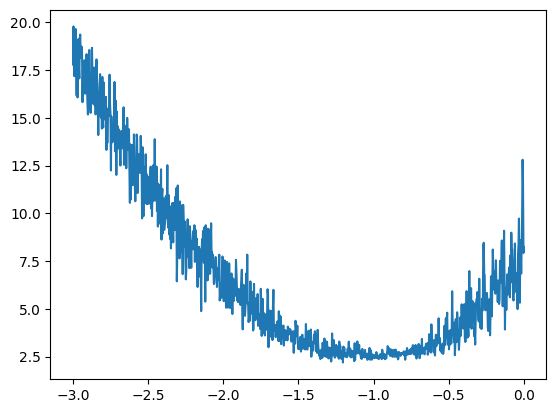

In [137]:
plt.plot(lr_track, loss_track)

In [ ]:
# large hidden layer, large embedding, visualizing embeddings